# RL coursework, part I (20 pts total)
---

**Name:** Sean Craven 

**SN:** 22185400

---

**Due date:** *27th March, 2023*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
rng = np.random.default_rng()

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return rng.integers(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    """
    First update the action values, then select the action with the highest
    expected reward.

    :param previous_action: The index of the action taken in the previous step.
    :param reward: _description_
    :return: index of 
    """
    if previous_action is None:
      return rng.integers(self._number_of_arms)
    
    self._update_action_values(previous_action, reward)
    return self._ucb_action_selection() 
  
  def _update_action_values(self, action: int, reward: float):
    """
    Performs iterative update on an estimate of the action taken's reward. 

    :param action: Action index of the action taken.
    :param reward:  Reward received for taking the action. 
    """
    self._action_values[action] = ((
      self._action_values[action] 
      * self._action_counts[action] 
      + reward
      ) 
      / (self._action_counts[action] + 1)
    )
    self._action_counts[action] += 1
    self._number_of_steps += 1

  def _ucb_action_selection(self)->int:
    """
    Selects an action based on the UCB algorithm. 
    """
    bonus = self._bonus_multiplier * np.sqrt(
      np.log(self._number_of_steps) / (self._action_counts + 1e-8)
    )
    return np.argmax(self._action_values + bonus)
    

    
    
  def reset(self):
    self._number_of_steps = 0
    self._action_values = np.zeros(self._number_of_arms)
    self._action_counts = np.zeros(self._number_of_arms)

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self.number_of_arms = number_of_arms
    self.reset()
    if isinstance(epsilon, float):
      self.epsilon =  epsilon
      self.epsilon_fn = None
    else:
      self.epsilon = 1
      self.epsilon_fn = epsilon

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is None:
      return rng.integers(self.number_of_arms)
    
    self._update_action_values(previous_action, reward)
    
    if self.epsilon_fn is not None:
      self.epsilon = self.epsilon_fn(self._number_of_steps)
      
    return self._epsilon_greedy_action_selection()
  
  
  def _update_action_values(self, action: int, reward: float):
    """
    Performs iterative update on an estimate of the action taken's reward. 

    :param action: Action index of the action taken.
    :param reward:  Reward received for taking the action. 
    """
    self._action_values[action] = ((
      self._action_values[action] 
      * self._action_counts[action] 
      + reward
      ) 
      / (self._action_counts[action] + 1)
    )
    self._action_counts[action] += 1
    self._number_of_steps += 1
  
  def _epsilon_greedy_action_selection(self):
    # 
    random_probs = np.ones_like(self.number_of_arms) * self.epsilon /self.number_of_arms
    best_actions = (np.max(self._action_values) == self._action_values)
    greedy_probs = best_actions* (1.0 - self.epsilon) / best_actions.sum()
    probs = random_probs + greedy_probs
    return np.random.choice(self.number_of_arms, p = probs)

  def reset(self):
    self._number_of_steps = 0
    self._action_values = np.zeros(self.number_of_arms)
    self._action_counts = np.zeros(self.number_of_arms)

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self.number_of_arms = number_of_arms
    self.step_size = step_size
    self.baseline = baseline
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is None:
      return rng.integers(self.number_of_arms)
    if self.baseline:
      self._update_baseline(reward)
    self._update_policy(previous_action, reward)
    
    return rng.choice(a=self.number_of_arms, p=squaremax_policy(self._parameters))
  
  def _update_baseline(self, reward):
    """Exponential average of the reward."""
    self._reward_baseline = self.step_size * reward + self._reward_baseline * (1-self.step_size)
  
  def _update_policy(self, previous_action, reward):
    """Gradient update to the policy using reinforce rule"""
    self._parameters += self.step_size* (reward- self._reward_baseline) * log_squarmax_derivateive(self._parameters, previous_action)
  

  def reset(self):
    self._parameters = np.ones((self.number_of_arms,))
    self._number_of_steps = 0
    self._action_values = np.zeros(self.number_of_arms)
    self._action_counts = np.zeros(self.number_of_arms)
    self._reward_baseline = 0
    

def squaremax_policy(parameters):
  """
  Returns probability of each action.

  :param parameters: the parameters of the square max distribution.
  :return:  probabilities 
  """
  return parameters**2/np.sum(parameters**2)


def log_squarmax_derivateive(parameters, action_taken):
  
  one_hot_action_encoding = np.zeros_like(parameters)
  one_hot_action_encoding[action_taken] = 1
  return 2 / parameters * (one_hot_action_encoding - parameters**2/np.sum(parameters**2))
  


# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

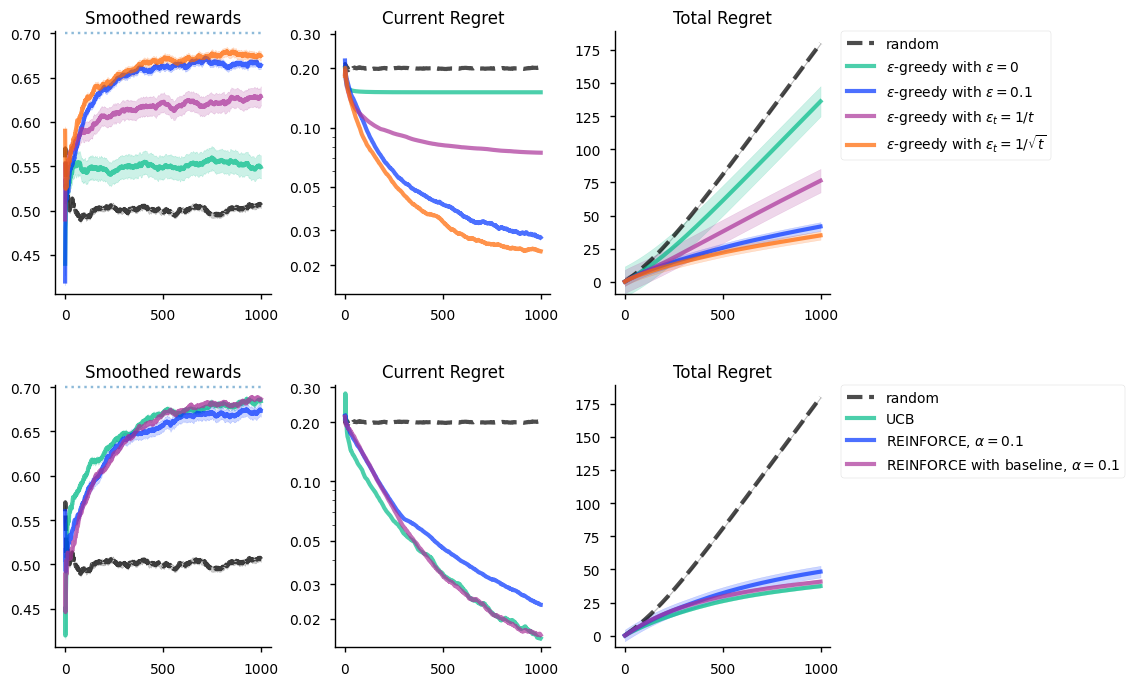

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

- UCB: The upper confidence bound agent, balances exploitation with smart exploration. If an action has the combined highest uncertainty in its value and expected reward then it is chosen. This gives it superior total regret performance as it doesn't explore actions that have weak expected rewards. 
- REINFORCE: This is a policy-based gradient method, where if an action has a positive reward the probability of this action is up-weighted. If the reward is negative then it is down-weighted. The stronger the reward the stronger the up-weighting is. For the first few epochs, the algorithm is close to true random, given that it is initialised uniformly. This means the initial regret performance is weak, however, it learns quite fast, to minimise the regret.
- REINFORCE with baseline: The algorithm here is almost the same however, rather than up-weighting the probability of a given action depending on a positive reward the reward is up/down-weighted depending on how much better it is than the baseline. This stops it from increasing the probability of mediocre actions and reduces the current and total regret. 
- Epsilon Greedy in the limit: $\epsilon \propto t^{-1}, \sqrt{t} ^{-1}$, both of these algorithms should converge in the infinite limit to the optimal policy, with 0 current regret. It appears that the $\sqrt{t}^{-1}$ scaling performs better on total regret, as it explores more and finds better estimates of the important action values.
- Epsilon Greedy: This policy will never achieve zero current regret, but performs well initially.
- Greedy: This policy has almost linear regret scaling as it doesn't explore. 

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

 - $\epsilon$-Greedy:
    - $\epsilon = 0$: This is the greedy limit. As there is no exploration if the initial value has a positive reward but negative regret, we expect the regret to grow linearly. As the value function is initialised to zero for all actions. Thus it should perform worse than the true random agent, if the action it takes first is worse than the average action.
    - $\epsilon = 0.1$: This policy balances exploration and exploitation. It is sufficiently random that it explores to find an action with low average regret. However, its regret will never be minimal for the system. Non-zero epsilon means even with the true values of $\mathbb{E}[R_{t+1}|A_t=a]$, the policy will pick suboptimal actions.
    - $\epsilon = t^{-1}$: This policy is much the same as the previous epsilon greedy policy. However, from the graphs, we see that the $\epsilon$ decays too fast for sufficient exploration to be done in the timeframe allowed, thus the policy becomes almost deterministic, on a poor action. To obtain good enough estimates of $\mathbb{E}[R_{t+1}| A_t=a]$, the agent ought to have explored more, as such we see a poor value for the total regret. In the infinite limit, it should recover both the best policy and the true expectation for all of the action rewards, however, its convergence is slow.
    - $\epsilon = t^{-1/2}$: The square root decay, strikes a balance between exploring, and converging to a greedy policy in the infinite exploration limit. As such it combines the benefits of an optimal fully greedy policy with sufficient exploration to get good estimates of $\mathbb{E}[R_{t+1}| A_t=a]$. And provides the minimum regret.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

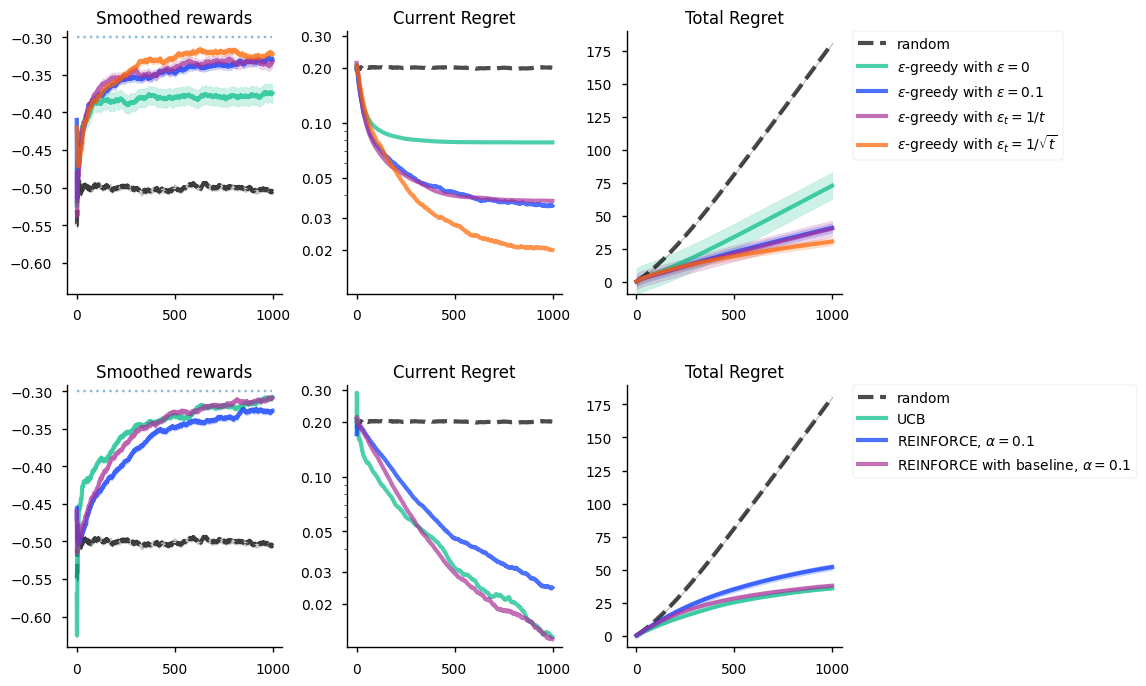

In [12]:

experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

- Greedy: This algorithm changes the most as it, now has the opportunity to explore as it is initialised with "Optimistic Initial values".
- $\epsilon$-Greedy: These algorithms all perform similarly as the problem is equivalent to their algorithm.
- REINFORCE/ REINFORCE with baseline: Performs the same as it is not sensitive to reward offsets.
- UCB: Performs the same as it is not sensitive to reward offsets.


## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

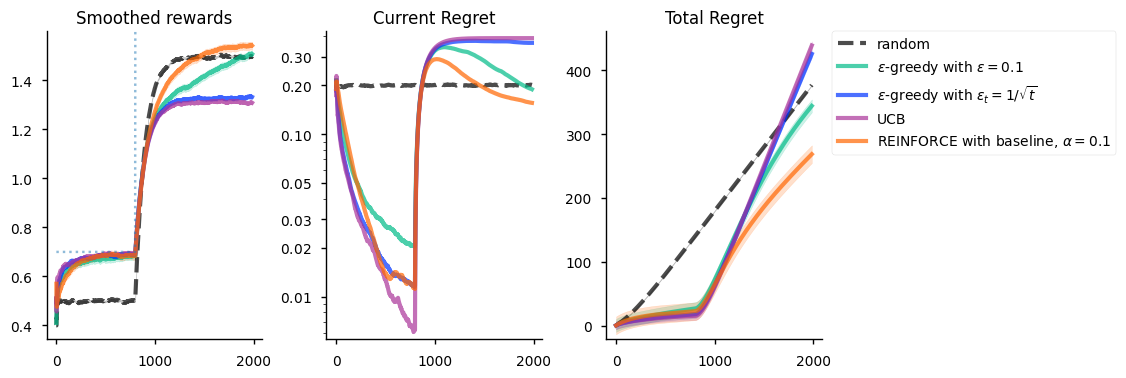

In [15]:
experiment3.show()

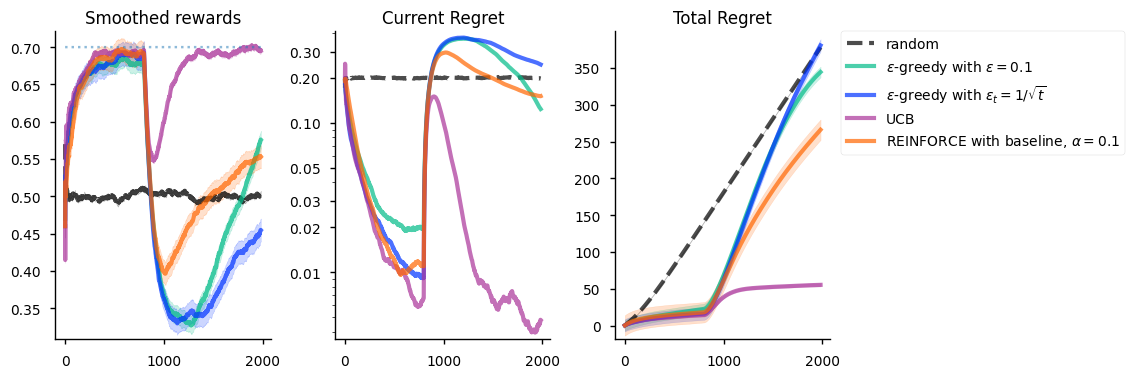

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

- REINFORCE: REINFORCE performs the best. This is a combination of two factors, firstly, as it "learns" at every time step a change in the rewards of the environment means that the policy changes, to respect this. When the failure reward changes to +2, this is significantly higher than the baseline, any time it takes an action and fails, the probabilities of this action are up-weighted, after the dynamics change, and it adapts online.

- $\epsilon$-Greedy: Epsilon greedy maintains a constant amount of exploration. Thus when the dynamics of the system change, it changes its beliefs about the value function accordingly, but in a slower manner than REINFORCE. 

- UCB: UCB, performs weakly in this test, as by time step 1000 it has high confidence on the best actions, that they are the best, when the dynamics change, the expected values of the previous best actions are only changed upwards and as such its policy doesn't change and it continues to not explore despite these actions not being optimal any more. 

- $\epsilon = \sqrt{t}^{-1}$-Greedy: By the time the dynamics change the value of $\epsilon$ is very small and the algorithm doesn't explore, sufficiently. as such the change to the true value function of actions is not updated in the agent's value function, as it doesn't explore enough to find the new optimal actions. However, in the limit of infinite exploration, it should recover the optimal policy and the true value function of the actions.

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

- UCB: UCB, performs strongly in this test, as by time step 1000 it has high confidence on the best actions, that they are the best, when the dynamics change, the expected values of the previous best actions are changed downwards. Because The agent has not taken the previously suboptimal actions much it has high uncertainty about their value. Thus it begins to explore the previously suboptimal values faster than any other algorithm and change its beliefs about how good these states are. 

- REINFORCE: REINFORCE performs similarly, this is because these examples are similar in terms of the performance of the algorithm, the baseline effectively offsets any reward offset. So the algorithm adapts online to the change with similar gradient updates.

- $\epsilon$-Greedy: Epsilon greedy maintains a constant amount of exploration. Thus when the dynamics of the system change, it changes its beliefs about the value function accordingly, but in a slower manner than REINFORCE. 

- $\epsilon = \sqrt{t}^{-1}$-Greedy: By the time the dynamics change the value of $\epsilon$ is very small and the algorithm doesn't explore, as such the change to the true value function of actions is not updated in the agent's value function, however, it performs slightly better than in the previous example as by epoch 1000 it is similar to a greedy agent with an optimistic baseline. 

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

In experiment 3 the change is to make originally bad actions much better, and originally good actions slightly better. By epoch 1000 the UCB agent doesn't do much exploration of the previously found good actions. In contrast, in experiment 4 when the rewards are inverted, the expectation of the reward for the originally good actions is reduced, as the originally poor actions have higher uncertainty, approximately $Q(\text{origionally bad, not changing till actions are selected}) + \text{ high uncertainty } > Q(\text{origionally good, and decreasing in time as actions are selected}) + \text{ low uncertainty}$. This inversion of the ordering between the UCBs causes it to explore the originally bad actions. It would not perform well if there was another inversion. REINFORCE or epsilon greedy would be better. 

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

We can perform a form of Thompson sampling where there is a strong prior, a beta distribution, on the rewards of each action to be unknown. Where the action taken on a step is the action with the highest posterior mean value, If the priors on the rewards are very uncertain then this will encourage the agent to explore more at all times than the UCB method. If we know the approximate timescales that the nonstationarity happens, resetting the agent on fixed intervals may also improve the performance.
